In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from statsmodels.graphics.api import abline_plot
from h2o.backend.server import H2OLocalServer
from h2o.automl import H2OAutoML
import numpy as np
import pickle

In [2]:
data=pd.read_csv('../input/train.csv',encoding='latin-1')

In [3]:
#id: only for test & sample submission files, id for prediction sample identification
#price: price in USD
#carat: weight of the diamond
#cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
#color: diamond colour, from J (worst) to D (best)
#clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
#x: length in mm
#y: width in mm
#z: depth in mm
#depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
#table: width of top of diamond relative to widest point (43--95)

In [4]:
#We will look at the data in order to understand it

In [5]:
data.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.12,Premium,H,SI1,61.6,59.0,6.67,6.63,4.10,5363
1,1,1.14,Very Good,E,SI2,60.0,54.0,6.74,6.97,4.11,5593
2,2,0.90,Very Good,D,SI2,60.3,63.0,6.12,6.22,3.72,3534
3,3,0.71,Ideal,E,VS1,61.9,54.0,5.74,5.76,3.56,3212
4,4,0.34,Very Good,F,SI2,60.0,62.0,4.51,4.55,2.72,447


In [6]:
data.shape

(40455, 11)

In [7]:
data.dtypes

id           int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

In [8]:
data.isna().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [9]:
data=data.drop_duplicates()

In [10]:
#There are not null values, neither duplicates

In [11]:
data['cut'].value_counts()

Ideal        16250
Premium      10342
Very Good     9026
Good          3639
Fair          1198
Name: cut, dtype: int64

In [12]:
data['color'].value_counts()

G    8565
E    7344
F    7162
H    6147
D    5063
I    4052
J    2122
Name: color, dtype: int64

In [13]:
data['clarity'].value_counts()

SI1     9806
VS2     9204
SI2     6865
VS1     6099
VVS2    3778
VVS1    2776
IF      1365
I1       562
Name: clarity, dtype: int64

In [14]:
#We want to check the price of the diamonds, just in case we want to split data according to those values afterwards

In [15]:
data.sort_values(by='price',ascending=False).head(10)

,id,carat,cut,color,clarity,depth,table,x,y,z,price
14955,14955,2.00,Very Good,G,SI1,63.5,56.0,7.90,7.97,5.04,18818
25017,25017,2.07,Ideal,G,SI2,62.5,55.0,8.20,8.13,5.11,18804
14089,14089,2.00,Very Good,H,SI1,62.8,57.0,7.95,8.00,5.01,18803
18387,18387,2.29,Premium,I,SI1,61.8,59.0,8.52,8.45,5.24,18797
5933,5933,2.04,Premium,H,SI1,58.1,60.0,8.37,8.28,4.84,18795
29475,29475,2.00,Premium,I,VS1,60.8,59.0,8.13,8.02,4.91,18795
36991,36991,1.71,Premium,F,VS2,62.3,59.0,7.57,7.53,4.70,18791
20794,20794,2.15,Ideal,G,SI2,62.6,54.0,8.29,8.35,5.21,18791
28955,28955,2.05,Ideal,G,SI1,61.9,57.0,8.10,8.16,5.03,18787
37011,37011,2.05,Premium,F,SI2,60.2,59.0,8.28,8.33,5.00,18784


In [16]:
dataplot=data.sort_values(by='price',ascending=True).reset_index()

In [17]:
dataplot=dataplot.reset_index()

Text(0, 0.5, 'Price USD')

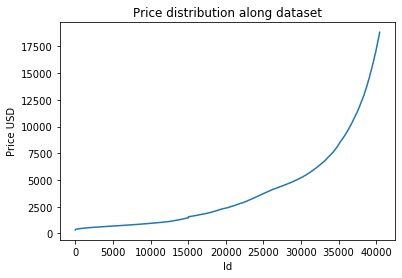

In [18]:
fig=sns.lineplot(dataplot['level_0'],dataplot['price'])
fig.set_title("Price distribution along dataset")
fig.set_xlabel("Id")
fig.set_ylabel("Price USD")

### Let's see the correlation matrix of the parameters we want to use

In [19]:
data_train=data.drop(['id'],axis=1)

In [20]:
columns={'cut','color','clarity'}

In [21]:
for column in columns:
    le = preprocessing.LabelEncoder()
    data_train[f"{column}_ord"] = le.fit_transform(data_train[column])

In [22]:
data_train

,carat,cut,color,clarity,depth,table,x,y,z,price,clarity_ord,cut_ord,color_ord
0,1.12,Premium,H,SI1,61.6,59.0,6.67,6.63,4.10,5363,2,3,4
1,1.14,Very Good,E,SI2,60.0,54.0,6.74,6.97,4.11,5593,3,4,1
2,0.90,Very Good,D,SI2,60.3,63.0,6.12,6.22,3.72,3534,3,4,0
3,0.71,Ideal,E,VS1,61.9,54.0,5.74,5.76,3.56,3212,4,2,1
4,0.34,Very Good,F,SI2,60.0,62.0,4.51,4.55,2.72,447,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0.90,Good,D,SI1,63.8,58.0,6.13,6.09,3.90,4120,2,1,0
40451,0.35,Ideal,D,VVS1,62.0,54.0,4.56,4.57,2.83,1266,6,2,0
40452,0.90,Good,G,SI2,58.4,55.0,6.34,6.39,3.72,3269,3,1,3
40453,1.21,Good,H,SI1,63.6,56.0,6.63,6.68,4.23,5893,2,1,4


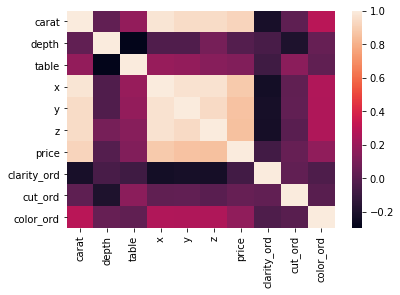

In [23]:
sns.heatmap(data_train.drop(['cut','color','clarity'],axis=1).corr())

In [24]:
X=data_train.drop(['cut','color','clarity'],axis=1)

In [25]:
X.head()

,carat,depth,table,x,y,z,price,clarity_ord,cut_ord,color_ord
0,1.12,61.6,59.0,6.67,6.63,4.10,5363,2,3,4
1,1.14,60.0,54.0,6.74,6.97,4.11,5593,3,4,1
2,0.90,60.3,63.0,6.12,6.22,3.72,3534,3,4,0
3,0.71,61.9,54.0,5.74,5.76,3.56,3212,4,2,1
4,0.34,60.0,62.0,4.51,4.55,2.72,447,3,4,2


In [26]:
pca2 = PCA(n_components=2)
data2d = pca2.fit_transform(X)

In [27]:
X.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'price', 'clarity_ord',
       'cut_ord', 'color_ord'],
      dtype='object')

In [28]:
X=pd.get_dummies(X)

In [29]:
X.shape

(40455, 10)

In [30]:
data_train=X[0:36410]

In [31]:
data_test=X[36410:]

### We set up the H2O model

In [32]:
predictors = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_ord', 'color_ord',
       'clarity_ord']
response ='price'
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /home/silviaherf/.local/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp33fhv1qh
  JVM stdout: /tmp/tmp33fhv1qh/h2o_silviaherf_started_from_python.out
  JVM stderr: /tmp/tmp33fhv1qh/h2o_silviaherf_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,"7 days, 15 hours and 54 minutes"
H2O_cluster_name:,H2O_from_python_silviaherf_q5nuzb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.857 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [33]:
data_train_fr = h2o.H2OFrame(data_train)
data_test_fr = h2o.H2OFrame(data_test)
data_fr=h2o.H2OFrame(X)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [34]:
aml = H2OAutoML(max_runtime_secs = 200)
aml.train(x=predictors,
              y=response,
              training_frame=data_train_fr)
lb = aml.leaderboard
print (lb)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20201006_072340,290228,538.728,290228,272.9,0.0963094
StackedEnsemble_BestOfFamily_AutoML_20201006_072340,292850,541.156,292850,275.692,0.0983744
GBM_grid__1_AutoML_20201006_072340_model_2,298974,546.785,298974,277.08,0.097547
GBM_grid__1_AutoML_20201006_072340_model_3,303918,551.288,303918,280.501,0.0998501
GBM_grid__1_AutoML_20201006_072340_model_1,315009,561.256,315009,292.505,nan
GBM_3_AutoML_20201006_072340,317326,563.317,317326,291.106,nan
XGBoost_grid__1_AutoML_20201006_072340_model_3,326296,571.223,326296,303.604,nan
GBM_1_AutoML_20201006_072340,329870,574.343,329870,302.728,0.115695
GBM_4_AutoML_20201006_072340,332076,576.26,332076,298.549,0.112838
XGBoost_1_AutoML_20201006_072340,333693,577.662,333693,294.005,0.102701


In [35]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20201006_072340

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 144259.4650531827
RMSE: 379.81504058315375
MAE: 211.48847878850526
RMSLE: 0.08152011588506297
R^2: 0.9909143871418082
Mean Residual Deviance: 144259.4650531827
Null degrees of freedom: 10058
Residual degrees of freedom: 10052
Null deviance: 159720613710.29294
Residual deviance: 1451105958.9699647
AIC: 148056.77614846124

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 290228.2257490005
RMSE: 538.7283413270555
MAE: 272.9004994494465
RMSLE: 0.09630938223442635
R^2: 0.9818165426275366
Mean Residual Deviance: 290228.2257490005
Null degrees of freedom: 36409
Residual degrees of freedom: 36401
Null deviance: 581158444564.0405
Residual deviance: 10567209699.521109
AIC: 561327.4809684238


### As results are satisfactory, we run AUTOMl for the whole dataset

In [62]:
aml2 = H2OAutoML(max_runtime_secs = 200)
aml2.train(x=predictors,
              y=response,
              training_frame=data_fr)
lb = aml.leaderboard
print (lb)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20201006_072340,290228,538.728,290228,272.9,0.0963094
StackedEnsemble_BestOfFamily_AutoML_20201006_072340,292850,541.156,292850,275.692,0.0983744
GBM_grid__1_AutoML_20201006_072340_model_2,298974,546.785,298974,277.08,0.097547
GBM_grid__1_AutoML_20201006_072340_model_3,303918,551.288,303918,280.501,0.0998501
GBM_grid__1_AutoML_20201006_072340_model_1,315009,561.256,315009,292.505,nan
GBM_3_AutoML_20201006_072340,317326,563.317,317326,291.106,nan
XGBoost_grid__1_AutoML_20201006_072340_model_3,326296,571.223,326296,303.604,nan
GBM_1_AutoML_20201006_072340,329870,574.343,329870,302.728,0.115695
GBM_4_AutoML_20201006_072340,332076,576.26,332076,298.549,0.112838
XGBoost_1_AutoML_20201006_072340,333693,577.662,333693,294.005,0.102701


In [64]:
aml2.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20201006_073124

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 133319.13809803317
RMSE: 365.1289335262726
MAE: 198.70410525618533
RMSLE: 0.07344250107595961
R^2: 0.9916712808821699
Mean Residual Deviance: 133319.13809803317
Null degrees of freedom: 10037
Residual degrees of freedom: 10031
Null deviance: 160683762842.13098
Residual deviance: 1338257508.2280571
AIC: 146956.03970807698

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 287051.5998394177
RMSE: 535.7719662686894
MAE: 268.8607310581166
RMSLE: 0.0919580969371713
R^2: 0.9819926714254472
Mean Residual Deviance: 287051.5998394177
Null degrees of freedom: 40454
Residual degrees of freedom: 40447
Null deviance: 644896609102.7832
Residual deviance: 11612672471.503643
AIC: 623239.1823374741


In [65]:
y_pred_test=aml2.leader.predict(data_test_fr)

stackedensemble prediction progress: |████████████████████████████████████| 100%


Text(0.5, 1.0, 'H2O Stacked Ensemble  Model')

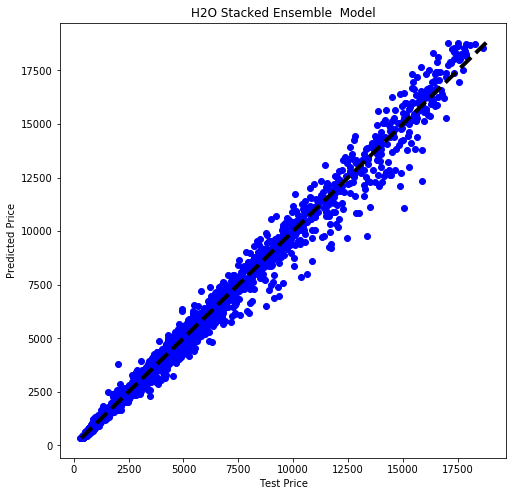

In [66]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(h2o.as_list(y_pred_test), data_test['price'], color="b")
ax.plot([data_test['price'].min(), data_test['price'].max()], [data_test['price'].min(), data_test['price'].max()], 'k--', lw=4)
ax.set_xlabel('Test Price')
ax.set_ylabel('Predicted Price')
ax.set_title("H2O Stacked Ensemble  Model")

### As results above are acceptable, we will save the model

In [67]:
filename = '../output/H2O2_4.sav'
pickle.dump(aml.leader, open(filename, 'wb'))

In [40]:
# load the model from disk afterwards
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Data test dataset importation before final prediction

In [68]:
dataset_test=pd.read_csv('../input/predict.csv',encoding='latin-1')

In [69]:
dataset_test=dataset_test.drop(['id'],axis=1)

In [70]:
dataset_test.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [71]:
dataset_test.shape

(13485, 9)

In [72]:
columns={'cut','color','clarity'}

In [73]:
for column in columns:
    le = preprocessing.LabelEncoder()
    dataset_test[f"{column}_ord"] = le.fit_transform(dataset_test[column])

In [74]:
X_final=dataset_test.drop(['cut','color','clarity'],axis=1)

In [75]:
X_final=pd.get_dummies(X_final)

In [76]:
X_final.head()

,carat,depth,table,x,y,z,clarity_ord,cut_ord,color_ord
0,0.33,62.0,58.0,4.44,4.46,2.76,1,4,5
1,1.21,62.4,58.0,6.77,6.83,4.24,3,4,0
2,1.06,59.3,60.0,6.64,6.71,3.96,2,4,0
3,0.36,61.4,57.0,4.64,4.61,2.54,6,2,1
4,0.70,62.3,54.0,5.67,5.72,3.55,4,2,1


In [77]:
X_final.shape

(13485, 9)

In [78]:
data_final_fr = h2o.H2OFrame(X_final)

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Price prediction with defined model

In [79]:
y_pred_final=aml2.leader.predict(data_final_fr)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [80]:
data_as_df = h2o.as_list(y_pred_final)

### We submit the attempt

In [81]:
submission=pd.DataFrame(data=data_as_df ).reset_index()

In [82]:
submission=submission.rename(columns={"index":"id",'predict': "price"})

In [83]:
submission.head()

,id,price
0,0,750.597273
1,1,6080.068983
2,2,5885.994973
3,3,1123.156850
4,4,3150.810532


In [85]:
submission.to_csv('../output/submissionH2O_4.csv',columns=['id','price'],index=False)  